In [ ]:
#default_exp modeling.seq2seq.translation

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.seq2seq.translation

> This module contains custom models, custom splitters, etc... translation tasks.

In [ ]:
#export
import ast, inspect, torch
from typing import Any, Callable, Dict, List, Optional, Union, Type

from datasets import load_metric as hf_load_metric, list_metrics as hf_list_metrics
from fastcore.all import *
from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter
from fastai.data.core import DataLoader, DataLoaders, TfmdDL
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, ranger, OptimWrapper, params
from fastai.torch_core import *
from fastai.torch_imports import *
from fastprogress.fastprogress import progress_bar,master_bar
from transformers import (
    AutoModelForSeq2SeqLM, logging,
    PretrainedConfig, PreTrainedTokenizerBase, PreTrainedModel
)

from blurr.utils import BLURR
from blurr.data.seq2seq.core import HF_Seq2SeqBlock, HF_Seq2SeqBeforeBatchTransform, default_text_gen_kwargs
from blurr.modeling.core import HF_BaseModelWrapper, HF_BaseModelCallback, HF_PreCalculatedLoss, Blearner
from blurr.modeling.seq2seq.core import HF_Seq2SeqMetricsCallback, seq2seq_splitter

logging.set_verbosity_error()

In [ ]:
#hide_input
import os, ast, inspect, pdb
from functools import reduce

from datasets import list_datasets, load_dataset
from fastai.data.external import untar_data, URLs
from fastcore.test import *
from nbverbose.showdoc import show_doc
from transformers import BartForConditionalGeneration

from blurr.utils import print_versions

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions('torch fastai transformers')

What we're running with at the time this documentation was generated:
torch: 1.7.1
fastai: 2.5.2
transformers: 4.9.2


In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Translation

Translation tasks attempt to convert text in one language into another

### Prepare the data

In [ ]:
ds = load_dataset('wmt16', 'de-en', split='train[:1%]')

Reusing dataset wmt16 (/home/wgilliam/.cache/huggingface/datasets/wmt16/de-en/1.0.0/0d9fb3e814712c785176ad8cdb9f465fbe6479000ee6546725db30ad8a8b5f8a)


In [ ]:
path = Path('./')
wmt_df = pd.DataFrame(ds['translation'], columns=['de', 'en']); len(wmt_df)

45489

In [ ]:
wmt_df = wmt_df.iloc[:1000]

In [ ]:
wmt_df.head(2)

,de,en
0,Wiederaufnahme der Sitzungsperiode,Resumption of the session
1,"Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.","I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period."


In [ ]:
pretrained_model_name = "Helsinki-NLP/opus-mt-de-en"
model_cls = AutoModelForSeq2SeqLM

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)
hf_arch, type(hf_tokenizer), type(hf_config), type(hf_model)

('marian',
 transformers.models.marian.tokenization_marian.MarianTokenizer,
 transformers.models.marian.configuration_marian.MarianConfig,
 transformers.models.marian.modeling_marian.MarianMTModel)

In [ ]:
blocks = (HF_Seq2SeqBlock(hf_arch, hf_config, hf_tokenizer, hf_model), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader('de'), get_y=ColReader('en'), splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(wmt_df, bs=2)

In [ ]:
b = dls.one_batch()

In [ ]:
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 141]), torch.Size([2, 83]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, input_trunc_at=250, target_trunc_at=250)

,text,target
0,"▁Angesichts▁dieser Situation▁muß▁aus dem▁Bericht, den das▁Parlament annimmt,▁klar▁hervorgehen,▁daß▁Maßnahmen▁notwendig▁sind, die▁eindeutig auf die▁Bekämpfung der relativen▁Armut und der Arbeitslosigkeit▁gerichtet▁sind.▁Maßnahmen▁wie die für diese▁Zwe","Given this situation, the report approved by Parliament must highlight the need for measures that aim unequivocally to fight relative poverty and unemployment: measures such as the appropriate use of structural funds for these purposes, which are oft"
1,"▁Ich▁kann▁jetzt nicht▁alle▁nennen:▁Einführung von▁sektorübergreifenden▁Maßnahmen,▁effizientere▁Nutzung▁öffentlicher▁Gelder,▁Unterstützung der▁unterschiedlichen Partner▁bei der▁gemeinsamen▁Entwicklung von▁regionalen oder▁nationalen▁Programmen▁usw. Die","I shall not list them all, but they include implementing intersectoral policies, increasing efficiency in the use of public funds, assisting the various partners in drawing up regional or national programming together, etc. The Commission takes note"


### Train model

In [ ]:
seq2seq_metrics = {
    'bleu': { 'returns': "bleu" },
    'meteor': { 'returns': "meteor" },
    'sacrebleu': { 'returns': "score" }
}

model = HF_BaseModelWrapper(hf_model)

learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(), #HF_PreCalculatedLoss()
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)) #.to_native_fp16() #.to_fp16()

learn.freeze()

[nltk_data] Downloading package wordnet to /home/wgilliam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#hide_output
learn.summary()

HF_BaseModelWrapper (Input shape: 2)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 83 x 512        
Embedding                                 29747712   False     
Embedding                                 29747712   False     
____________________________________________________________________________
                     2 x 512             
MarianSinusoidalPositionalEmbedding                      262144     False     
Linear                                    262656     False     
Linear                                    262656     False     
Linear                                    262656     False     
Linear                                    262656     False     
LayerNorm                                 1024       True      
____________________________________________________________________________
                     2 x 141 x 2048      
Linear                                    1050624    False     
____________________________

In [ ]:
# b = dls.one_batch()
# preds = learn.model(b[0])

# len(preds),preds['loss'].shape, preds['logits'].shape

In [ ]:
len(b), len(b[0]), b[0]['input_ids'].shape, len(b[1]), b[1].shape

(2, 3, torch.Size([2, 141]), 2, torch.Size([2, 83]))

In [ ]:
print(len(learn.opt.param_groups))

3


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(minimum=0.00012022644514217973, steep=9.12010818865383e-07, valley=9.120108734350652e-05, slide=4.365158383734524e-05)

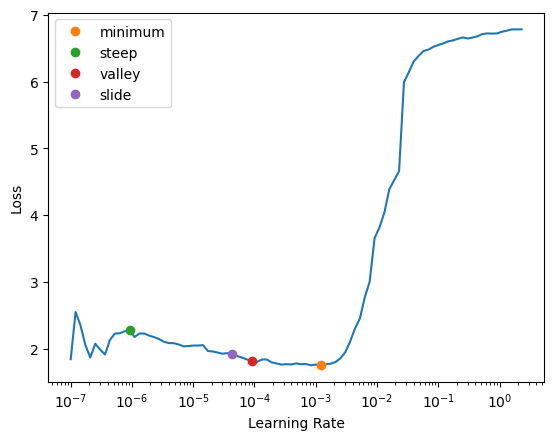

In [ ]:
#slow
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
#slow
learn.fit_one_cycle(1, lr_max=4e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,bleu,meteor,sacrebleu,time
0,1.292981,1.263649,0.320008,0.540354,31.188232,00:59


In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=500)

,text,target,prediction
0,"Aus▁diesem Grund▁ist es▁eines der▁wichtigsten und▁weitreichendsten▁Ziele, die wir▁uns in der▁Europäischen Union▁stellen▁sollten,▁Anstrengungen zur▁Schaffung▁neuer▁Arbeitsplätze in den▁ländlichen▁Gebieten▁außerhalb des▁Agrarsektors zu▁unternehmen,▁unter▁anderem in den▁Bereichen▁ländlicher▁Tourismus, Sport, Kultur,▁Sanierung der▁Ressourcen,▁Umstellung von▁Unternehmen,▁neue▁Technologien,▁Dienstleistungen▁usw.▁Doch▁obwohl die▁Landwirtschaft▁keine▁ausschließliche▁Rolle▁mehr▁spielt,▁ist▁sie▁weiterhin▁","For this reason, one of the most important and essential objectives which we should set in the European Union is to make efforts to create new jobs in rural areas, outside of the agricultural sector, in sectors such as rural tourism, sport, culture, heritage conservation, the conversion of businesses, new technologies, services, etc. However, even though the role of agriculture is not exclusive, it is still essential, not only to prevent economic and social disintegration and the creation of gho","For this reason, it is one of the most important and far-reaching objectives that we should set ourselves in the European Union to make efforts to create new jobs in rural areas outside the agricultural sector, including in the areas of rural tourism, sport, culture, rehabilitation of resources, conversion of businesses, new technologies, services, etc. However, although agriculture no longer plays an exclusive role, it is still important, not only to prevent the economic and social decline of r"
1,"Es▁muß▁daran▁erinnert▁werden,▁daß die▁globale▁Wettbewerbsfähigkeit der▁Europäischen Union▁gegenwärtig 81 % des▁Niveaus der▁Vereinigten▁Staaten von▁Amerika▁erreicht und▁daß diese▁Kennziffer sich▁nur▁dann▁verbessern▁wird,▁wenn sich die▁unserer wettbewerbsfähigen▁Wirtschaftseinheiten,▁nämlich der▁Regionen,▁verbessert, und das zu▁einem▁Zeitpunkt, da die▁technologische▁Entwicklung, die▁Globalisierung der Wirtschaft und▁unsere▁Probleme, die▁Erweiterung und die▁Einheitswährung, von den▁Regionen,▁aber▁a","It must be remembered that, currently, the European Union' s overall competitiveness is, in general terms, 81% of that of the United States of America and that this figure will only improve if the figure for our competitive units, that is the regions, also improves. Furthermore, this is at a time when technological development, economic globalisation and our problems, which are enlargement and the single currency, demand that the regions, as well as businesses and individuals, make more of an ef","It should be recalled that the European Union' s overall competitiveness is currently reaching 81% of the level of the United States of America and that this figure will only improve if our competitive economic units, namely the regions, improve, at a time when technological development, the globalisation of the economy and our problems, enlargement and the single currency, demand greater competition from the regions, but also from businesses and individuals."


In [ ]:
test_de = "Ich trinke gerne Bier"

In [ ]:
outputs = learn.blurr_generate(test_de, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
I like to drink beer

=== Prediction 2 ===
I like to drink beer.

=== Prediction 3 ===
I like drinking beer



### Inference

In [ ]:
export_fname = 'translation_export'

In [ ]:
learn.metrics = None
learn.export(fname=f'{export_fname}.pkl')

In [ ]:
inf_learn = load_learner(fname=f'{export_fname}.pkl')
inf_learn.blurr_generate(test_de)

['I like to drink beer']

## High-level API

### BlearnerForTranslation

We also introduce a task specific `Blearner` that get you your DataBlock, DataLoaders, and BLearner in one line of code!

In [ ]:
#hide
try: del learn; del inf_learn; torch.cuda.empty_cache()
except: pass

In [ ]:
#export
@delegates(Blearner.__init__)
class BlearnerForTranslation(Blearner):

    def __init__(
        self, 
        dls: DataLoaders, 
        hf_model: PreTrainedModel, 
        **kwargs
    ):
        super().__init__(dls, hf_model, **kwargs)
            
    @classmethod
    def get_model_cls(cls): 
        return AutoModelForSeq2SeqLM
    
    @classmethod
    def _add_t5_prefix(cls, inp, src_lang_name, trg_lang_name): 
        return f'translate {src_lang_name} to {trg_lang_name}: {inp}'
    
    @classmethod
    def get_metrics_cb(self):
        seq2seq_metrics = {
            'bleu': { 'returns': "bleu" },
            'meteor': { 'returns': "meteor" },
            'sacrebleu': { 'returns': "score" }
        }
            
        return HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)
    
    @classmethod
    def _create_learner(
        cls, 
        # Your raw dataset
        data, 
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path:Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset 
        preprocess_func:Callable=None, 
        # The language of your source (inputs)
        src_lang_name:str='English', 
        # The attribute/column of your source language texts
        src_lang_attr:str='src_lang', 
        # The attribute/column of your target language texts
        trg_lang_name:str='English',
        # The attribute/column of your target language texts (this is what you want to predict)
        trg_lang_attr:str='trg_lang', 
        # The max length of your raw text to consider for summarization
        max_length:Union[int,str]=None, 
        # The max length of your targets (sumamrized) text
        max_target_length:Union[int,str]=None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter:Callable=RandomSplitter(),
        # Any additional keyword arguments applied during tokenization
        hf_tok_kwargs:dict={}, 
        # If you want to override your Blurr transform's `text_gen_kwargs`, do that here
        text_gen_kwargs:dict={}, 
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs:dict={}, 
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs:dict={}
    ):
        # we need to find the architecture to ensure "mbart" specific tokenizer kwargs are included
        model_cls = cls.get_model_cls()
        model = model_cls.from_pretrained(pretrained_model_name_or_path)
        hf_arch = BLURR.get_model_architecture(type(model).__name__)

        if (hf_arch == 'mbart'): 
            hf_tok_kwargs = { **{'src_lang': 'en_XX', 'tgt_lang': 'en_XX'}, **hf_tok_kwargs }
            
        # get our hf objects
        hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name_or_path, 
                                                                          model_cls=model_cls, 
                                                                          tokenizer_kwargs=hf_tok_kwargs)
        
        # if we need to preprocess the raw data before creating our DataLoaders
        if (preprocess_func):
            data = preprocess_func(data, hf_arch, hf_config, hf_tokenizer, hf_model, text_attr, summary_attr)
            
        # update text generation kwargs
        text_gen_kwargs = { **text_gen_kwargs, **default_text_gen_kwargs(hf_config, hf_model, task='translation') }
        
        # not all "summarization" parameters are for the model.generate method ... remove them here
        generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
        for k in text_gen_kwargs.copy():
            if k not in generate_func_args: del text_gen_kwargs[k]
                
        # update our text generation kwargs for mbart
        if (hf_arch == 'mbart'):
            text_gen_kwargs = { **{'decoder_start_token_id': 'en_XX'}, **text_gen_kwargs }
            
        # build dblock, dls, and default metrics (optional)
        if (isinstance(data, pd.DataFrame)):
            get_x = Pipeline(funcs=[ColReader(src_lang_attr)])
            get_y = ColReader(trg_lang_attr)
        else:
            get_x = Pipeline(funcs=[ItemGetter(src_lang_attr)])
            get_y = ItemGetter(trg_lang_attr)
                               
        if (hf_arch == 't5'):
            get_x.add(partial(cls._add_t5_prefix, src_lang_name=src_lang_name, trg_lang_name=trg_lang_name))
            
        before_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                                          max_length=max_length, 
                                                          max_target_length=max_target_length, 
                                                          text_gen_kwargs=text_gen_kwargs)
        
        blocks = (HF_Seq2SeqBlock(before_batch_tfm=before_batch_tfm), noop)
        dblock = DataBlock(blocks=blocks, 
                           get_x=get_x, 
                           get_y=get_y, 
                           splitter=dblock_splitter)
        
        dls = dblock.dataloaders(data, **dl_kwargs.copy())
        
        # return BLearner instance
        learner_kwargs['splitter'] = learner_kwargs.pop('splitter', partial(seq2seq_splitter, arch=hf_arch))
        learner_kwargs['loss_func'] = learner_kwargs.pop('loss_func', CrossEntropyLossFlat())
        return cls(dls, hf_model, **learner_kwargs.copy())
    
    @classmethod
    def from_dataframe(
        cls, 
        # Your pandas DataFrame
        df, 
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path:Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset 
        preprocess_func:Callable=None, 
        # The language of your source (inputs)
        src_lang_name:str='English', 
        # The attribute/column of your source language texts
        src_lang_attr:str='src_lang', 
        # The attribute/column of your target language texts
        trg_lang_name:str='English',
        # The attribute/column of your target language texts (this is what you want to predict)
        trg_lang_attr:str='trg_lang', 
        # The max length of your raw text to consider for summarization
        max_length:Union[int,str]=None, 
        # The max length of your targets (sumamrized) text
        max_target_length:Union[int,str]=None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter:Callable=RandomSplitter(),
        # Any additional keyword arguments applied during tokenization
        hf_tok_kwargs:dict={}, 
        # If you want to override your Blurr transform's `text_gen_kwargs`, do that here
        text_gen_kwargs:dict={}, 
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs:dict={}, 
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs:dict={}
    ):
        return cls._create_learner(df, 
                                   pretrained_model_name_or_path=pretrained_model_name_or_path, 
                                   preprocess_func=preprocess_func, 
                                   src_lang_name=src_lang_name, 
                                   src_lang_attr=src_lang_attr, 
                                   trg_lang_name=trg_lang_name, 
                                   trg_lang_attr=trg_lang_attr, 
                                   max_length=max_length, 
                                   max_target_length=max_target_length,  
                                   dblock_splitter=dblock_splitter, 
                                   hf_tok_kwargs=hf_tok_kwargs, text_gen_kwargs=text_gen_kwargs, 
                                   dl_kwargs=dl_kwargs, learner_kwargs=learner_kwargs)
    
        
    @classmethod
    def from_csv(
        cls, 
        # The path to your csv file
        csv_file:Union[Path, str],
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path:Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset 
        preprocess_func:Callable=None, 
        # The language of your source (inputs)
        src_lang_name:str='English', 
        # The attribute/column of your source language texts
        src_lang_attr:str='src_lang', 
        # The attribute/column of your target language texts
        trg_lang_name:str='English',
        # The attribute/column of your target language texts (this is what you want to predict)
        trg_lang_attr:str='trg_lang', 
        # The max length of your raw text to consider for summarization
        max_length:Union[int,str]=None, 
        # The max length of your targets (sumamrized) text
        max_target_length:Union[int,str]=None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter:Callable=RandomSplitter(),
        # Any additional keyword arguments applied during tokenization
        hf_tok_kwargs:dict={}, 
        # If you want to override your Blurr transform's `text_gen_kwargs`, do that here
        text_gen_kwargs:dict={}, 
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs:dict={}, 
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs:dict={}
    ):
        df = pd.read_csv(csv_file)
        
        return cls.from_dataframe(df, 
                                  pretrained_model_name_or_path=pretrained_model_name_or_path, 
                                  preprocess_func=preprocess_func, 
                                  src_lang_name=src_lang_name, 
                                  src_lang_attr=src_lang_attr, 
                                  trg_lang_name=trg_lang_name, 
                                  trg_lang_attr=trg_lang_attr, 
                                  max_length=max_length, 
                                  max_target_length=max_target_length,  
                                  dblock_splitter=dblock_splitter, 
                                  hf_tok_kwargs=hf_tok_kwargs, text_gen_kwargs=text_gen_kwargs, 
                                  dl_kwargs=dl_kwargs, learner_kwargs=learner_kwargs)
    
    @classmethod
    def from_dictionaries(
        cls, 
        # A list of dictionaries
        ds:List[Dict], 
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path:Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset 
        preprocess_func:Callable=None, 
        # The language of your source (inputs)
        src_lang_name:str='English', 
        # The attribute/column of your source language texts
        src_lang_attr:str='src_lang', 
        # The attribute/column of your target language texts
        trg_lang_name:str='English',
        # The attribute/column of your target language texts (this is what you want to predict)
        trg_lang_attr:str='trg_lang', 
        # The max length of your raw text to consider for summarization
        max_length:Union[int,str]=None, 
        # The max length of your targets (sumamrized) text
        max_target_length:Union[int,str]=None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter:Callable=RandomSplitter(),
        # Any additional keyword arguments applied during tokenization
        hf_tok_kwargs:dict={}, 
        # If you want to override your Blurr transform's `text_gen_kwargs`, do that here
        text_gen_kwargs:dict={}, 
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs:dict={}, 
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs:dict={}
    ):
        return cls._create_learner(ds, 
                                   pretrained_model_name_or_path=pretrained_model_name_or_path, 
                                   preprocess_func=preprocess_func, 
                                   src_lang_name=src_lang_name, 
                                   src_lang_attr=src_lang_attr, 
                                   trg_lang_name=trg_lang_name, 
                                   trg_lang_attr=trg_lang_attr, 
                                   max_length=max_length, 
                                   max_target_length=max_target_length,  
                                   dblock_splitter=dblock_splitter, 
                                   hf_tok_kwargs=hf_tok_kwargs, text_gen_kwargs=text_gen_kwargs, 
                                   dl_kwargs=dl_kwargs, learner_kwargs=learner_kwargs)
    

In [ ]:
learn = BlearnerForTranslation.from_dataframe(wmt_df, 'Helsinki-NLP/opus-mt-de-en', 
                                              src_lang_name='German', src_lang_attr='de', 
                                              trg_lang_name='English', trg_lang_attr='en', 
                                              dblock_splitter=RandomSplitter(),
                                              dl_kwargs={'bs':2})

In [ ]:
metrics_cb = BlearnerForTranslation.get_metrics_cb()
learn.fit_one_cycle(1, lr_max=4e-5, cbs=[metrics_cb])

[nltk_data] Downloading package wordnet to /home/wgilliam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


epoch,train_loss,valid_loss,bleu,meteor,sacrebleu,time
0,1.326087,1.324222,0.308548,0.511621,30.511772,00:57


In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)

,text,target,prediction
0,"▁Angesichts▁dieser Situation▁muß▁aus dem▁Bericht, den das▁Parlament annimmt,▁klar▁hervorgehen,▁daß▁Maßnahmen▁notwendig▁sind, die▁eindeutig auf die▁Bekämpfung der relativen▁Armut und der Arbeitslosigkeit▁gerichtet▁sind.▁Maßnahmen▁wie die für diese▁Zwecke▁angemessene▁Verwendung der▁Strukturfonds, die▁häufig▁unsachgemäß▁eingesetzt▁werden, und▁zwar mit▁zentralen▁staatlichen▁Politiken, die▁Modernisierung der▁Bereiche Telekommunikation und▁Kommunikation,▁indem man vor▁allem die am▁wenigsten▁entwickelt","Given this situation, the report approved by Parliament must highlight the need for measures that aim unequivocally to fight relative poverty and unemployment: measures such as the appropriate use of structural funds for these purposes, which are oft","In view of this situation, the report adopted by Parliament must clearly show the need for measures which are clearly aimed at combating relative poverty and unemployment, such as the use of the Structural Funds, which are often used improperly for t"
1,"▁Deshalb▁besteht der▁Vorschlag der▁Fraktion der▁Sozialdemokratischen▁Partei▁Europas, den Sie▁erwähnt▁haben,▁darin, den▁Mittwoch▁als▁Termin der▁Vorstellung des▁Programms der▁Kommission Prodi für die▁Wahlperiode▁beizubehalten, und in▁dieses▁Programm▁auch das▁Verwaltungsreformprojekt▁einzubeziehen, da wir▁andernfalls in eine paradoxe Situation▁geraten▁könnten: Mit der Ausrede, der▁Wortlaut liege nicht vor,▁wird▁einerseits dem▁Präsidenten der▁Kommission das▁Recht▁abgesprochen, in▁diesem▁Parlament zu","Therefore, the proposal of the Group of the Party of European Socialists, and which you have mentioned, is that the Prodi Commission present its legislative programme on Wednesday, including its proposed administrative reform, because, otherwise, we","That is why the proposal of the Group of the Party of European Socialists, which you have mentioned, is to maintain Wednesday as the date for the presentation of the Prodi Commission' s programme for the parliamentary term, and to include in this pro"


In [ ]:
test_de = "Ich trinke gerne Bier"

In [ ]:
learn.blurr_generate(test_de)

['I like to drink beer']

In [ ]:
export_fname = 'translation_export'

learn.metrics = None
learn.export(fname=f'{export_fname}.pkl')

inf_learn = load_learner(fname=f'{export_fname}.pkl')
inf_learn.blurr_generate(test_de)

['I like to drink beer']

## Tests

The purpose of the following tests is to ensure as much as possible, that the core training code works for the pretrained **translation models** below.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained summarization models you are working with ... and if any of your pretrained translation models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
try: del learn; torch.cuda.empty_cache()
except: pass

In [ ]:
[ model_type for model_type in BLURR.get_models(task='ConditionalGeneration') 
 if (not model_type.startswith('TF')) ]

['BartForConditionalGeneration',
 'BigBirdPegasusForConditionalGeneration',
 'BlenderbotForConditionalGeneration',
 'BlenderbotSmallForConditionalGeneration',
 'FSMTForConditionalGeneration',
 'LEDForConditionalGeneration',
 'M2M100ForConditionalGeneration',
 'MBartForConditionalGeneration',
 'MT5ForConditionalGeneration',
 'PegasusForConditionalGeneration',
 'ProphetNetForConditionalGeneration',
 'Speech2TextForConditionalGeneration',
 'T5ForConditionalGeneration',
 'XLMProphetNetForConditionalGeneration']

In [ ]:
pretrained_model_names = [
    'facebook/bart-base',
    'facebook/wmt19-de-en',                      # FSMT
    'Helsinki-NLP/opus-mt-de-en',                # MarianMT
    #'sshleifer/tiny-mbart',
    #'google/mt5-small',
    't5-small'
]

In [ ]:
path = Path('./')
ds = load_dataset('wmt16', 'de-en', split='train[:1%]')
wmt_df = pd.DataFrame(ds['translation'], columns=['de', 'en']); len(wmt_df)
wmt_df = wmt_df.iloc[:1000]

Reusing dataset wmt16 (/home/wgilliam/.cache/huggingface/datasets/wmt16/de-en/1.0.0/0d9fb3e814712c785176ad8cdb9f465fbe6479000ee6546725db30ad8a8b5f8a)


In [ ]:
#slow
#hide_output
model_cls = AutoModelForSeq2SeqLM
bsz = 2
inp_seq_sz = 128; trg_seq_sz = 128

test_results = []
for model_name in pretrained_model_names:
    error=None
    
    print(f'=== {model_name} ===\n')
    
    hf_tok_kwargs = {}
    if (model_name == 'sshleifer/tiny-mbart'):
        hf_tok_kwargs['src_lang'], hf_tok_kwargs['tgt_lang'] = "de_DE", "en_XX"
            
    
    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(model_name, 
                                                                      model_cls=model_cls, 
                                                                      tokenizer_kwargs=hf_tok_kwargs)
    
    print(f'architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\nmodel:\t\t{type(hf_model).__name__}\n')
    
    # 1. build your DataBlock
    text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='translation')
    
    def add_t5_prefix(inp): return f'translate German to English: {inp}' if (hf_arch == 't5') else inp
    
    before_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                                      padding='max_length', 
                                                      max_length=inp_seq_sz, 
                                                      max_target_length=trg_seq_sz, 
                                                      text_gen_kwargs=text_gen_kwargs)
    
    blocks = (HF_Seq2SeqBlock(before_batch_tfm=before_batch_tfm), noop)
    dblock = DataBlock(blocks=blocks, 
                   get_x=Pipeline([ColReader('de'), add_t5_prefix]), 
                   get_y=ColReader('en'), 
                   splitter=RandomSplitter())

    dls = dblock.dataloaders(wmt_df, bs=bsz) 
    b = dls.one_batch()

    # 2. build your Learner
    seq2seq_metrics = {}
    
    model = HF_BaseModelWrapper(hf_model)
    fit_cbs = [
        ShortEpochCallback(0.05, short_valid=True), 
        HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)
    ]

    learn = Learner(dls, 
                    model,
                    opt_func=ranger,
                    loss_func=HF_PreCalculatedLoss(),
                    cbs=[HF_BaseModelCallback],
                    splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

    learn.create_opt() 
    learn.freeze()
    
    # 3. Run your tests
    try:
        print('*** TESTING DataLoaders ***\n')
        test_eq(len(b), 2)
        test_eq(len(b[0]['input_ids']), bsz)
        test_eq(b[0]['input_ids'].shape, torch.Size([bsz, inp_seq_sz]))
        test_eq(len(b[1]), bsz)

#         print('*** TESTING One pass through the model ***')
#         preds = learn.model(b[0])
#         test_eq(preds[1].shape[0], bsz)
#         test_eq(preds[1].shape[2], hf_config.vocab_size)

        print('*** TESTING Training/Results ***')
        learn.fit_one_cycle(1, lr_max=1e-3, cbs=fit_cbs)

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'PASSED', ''))
        learn.show_results(learner=learn, max_n=2, input_trunc_at=500, target_trunc_at=250)
    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'FAILED', err))
    finally:
        # cleanup
        del learn; torch.cuda.empty_cache()

=== facebook/bart-base ===

architecture:	bart
tokenizer:	BartTokenizerFast
model:		BartForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"Nach meiner Ansicht würde diese zweite Hypothese einem Verzicht auf unsere Verantwortung als Parlament und darüber hinaus dem Aufwerfen einer originellen These, einer unbekannten Methode gleichkommen, die darin bestände, den Fraktionen die programmatische Rede der Kommission in schriftlicher Form eine Woche vorher - und nicht, wie vereinbart, am Tag zuvor -","In my opinion, this second hypothesis would imply the failure of Parliament in its duty as a Parliament, as well as introducing an original thesis, an unknown method which consists of making political groups aware, in writing, of a speech concerning",Nach meiner Ansicht würde diese zweite Hypothese
1,"Es muß daran erinnert werden, daß die globale Wettbewerbsfähigkeit der Europäischen Union gegenwärtig 81 % des Niveaus der Vereinigten Staaten von Amerika erreicht und daß diese Kennziffer sich nur dann verbessern wird, wenn sich die unserer wettbewerbsfähigen Wirtschaftseinheiten, nämlich der Regionen, verbessert, und das zu einem","It must be remembered that, currently, the European Union' s overall competitiveness is, in general terms, 81% of that of the United States of America and that this figure will only improve if the figure for our competitive units, that is the region","Es muß daran erinnert werden, daß die globale"


=== facebook/wmt19-de-en ===

architecture:	fsmt
tokenizer:	FSMTTokenizer
model:		FSMTForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"Angesichts dessen müssen wir in diesem Parlament auf jeden Fall verlangen, daß die gemeinschaftlichen Förderkonzepte für den fraglichen Zeitraum in diesem Parlament vor ihrer Annahme geprüft und erörtert werden, und zwar anhand der Leitlinien, die wir heute vorlegen, denn wir halten sie für ganz besonders geeignet, Arbeitsplätze in den ärmsten oder am wenigsten entwickelten Regionen zu schaffen, und so tragen wir dazu bei, den negativen, zur Ungleichheit führenden Tendenzen in der europäischen G","Bearing this in mind, this House should, in any event, demand that, before the Community support frameworks for the period in question are approved, they be studied and submitted for debate in this Parliament, specifically in light of the guidelines","In view of this, we in this Parliament must, in any case, demand that the Community support frameworks for the period in question be examined and discussed in this Parliament before they are adopted, on the basis of the guidelines we are presenting t"
1,"Die Lage ist ernst, denn es gibt heute sogar in der Europäischen Union einen offensichtlichen Zusammenhang zwischen Arbeitslosigkeit und Armut, wie die äußerst besorgniserregende Tatsache beweist, daß die Arbeitslosigkeit in den von diesem Problem am stärksten betroffenen Regionen durchschnittlich 23,7% erreicht, und diese Regionen decken sich mit Armutsgebieten, während in den 25 Regionen mit geringerer Arbeitslosigkeit, die den wohlhabenden Gebieten entsprechen, die Arbeitslosigkeit nur bei 4%","We have a serious situation in which in the European Union today, there is a genuine link between unemployment and poverty, as demonstrated by the very worrying fact that unemployment has reached, on average, 23.7% in the regions worst affected, regi","The situation is serious because, even in the European Union today, there is an obvious link between unemployment and poverty, as is shown by the extremely worrying fact that unemployment in the regions most affected by this problem reaches an averag"


=== Helsinki-NLP/opus-mt-de-en ===

architecture:	marian
tokenizer:	MarianTokenizer
model:		MarianMTModel

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"▁Deshalb▁besteht der▁Vorschlag der▁Fraktion der▁Sozialdemokratischen▁Partei▁Europas, den Sie▁erwähnt▁haben,▁darin, den▁Mittwoch▁als▁Termin der▁Vorstellung des▁Programms der▁Kommission Prodi für die▁Wahlperiode▁beizubehalten, und in▁dieses▁Programm▁auch das▁Verwaltungsreformprojekt▁einzubeziehen, da wir▁andernfalls in eine paradoxe Situation▁geraten▁könnten: Mit der Ausrede, der▁Wortlaut liege nicht vor,▁wird▁einerseits dem▁Präsidenten der▁Kommission das▁Recht▁abgesprochen, in▁diesem▁Parlament zu","Therefore, the proposal of the Group of the Party of European Socialists, and which you have mentioned, is that the Prodi Commission present its legislative programme on Wednesday, including its proposed administrative reform, because, otherwise, we","That is why the proposal of the Group of the Party of European Socialists, which you have mentioned, is to maintain Wednesday as the date for the presentation of the Prodi Commission's programme for the parliamentary term, and to include in this prog"
1,"Die▁Verkehrssicherheit▁bestimmte in▁letzter Zeit▁häufig die▁Negativschlagzeilen: Das▁Eisenbahnunglück▁nahe dem▁Londoner▁Bahnhof Paddington, das▁furchtbare▁Eisenbahnunglück in▁Norwegen,▁zwei▁Flugzeugabstürze,▁bei▁denen EU-Bürger zu▁Schaden▁kamen, und die von der Erika vor der bretonischen▁Küste▁verursachte Naturkatastrophe▁sind▁Ereignisse, die▁allein in den▁letzten▁vier▁Monaten zu▁verzeichnen▁waren. Sie▁machen▁deutlich,▁daß▁Verkehrssicherheit▁keine▁Selbstverständlichkeit▁ist und▁daß▁diejenigen, d","Transport safety has sadly been in the news recently: the Paddington rail crash in London, the terrible rail crash in Norway, the two aviation crashes involving EU citizens and the natural disaster involving the Erika off Brittany - all within the la","In recent years, road safety has often defined the negative headlines: the railway accident near London's Paddington station, the terrible railway accident in Norway, two aircraft crashes causing damage to EU citizens, and the natural disaster caused"


=== t5-small ===

architecture:	t5
tokenizer:	T5TokenizerFast
model:		T5ForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"translate German to English: Angesichts dieser Situation muß aus dem Bericht, den das Parlament annimmt, klar hervorgehen, daß Maßnahmen notwendig sind, die eindeutig auf die Bekämpfung der relativen Armut und der Arbeitslosigkeit gerichtet sind. Maßnahmen wie die für diese Zwecke angemessene Verwendung der Strukturfonds, die häufig unsachgemäß eingesetzt werden, und zwar mit zentralen staatlichen Politiken, die Modernisierung der Bereiche Telekommunikation und Kommunikation, indem man vor allem","Given this situation, the report approved by Parliament must highlight the need for measures that aim unequivocally to fight relative poverty and unemployment: measures such as the appropriate use of structural funds for these purposes, which are oft","Angesichts dieser Situation muß aus dem Bericht, den das Parlament annimmt, klar"
1,"translate German to English: Aufgrund meinen Vorstellungen vom Aufbau Europas und von regionaler Entwicklungspolitik im besonderen halte ich das für eine Situation, die ich nicht akzeptieren kann. Ich habe die Absicht, im Rahmen meiner Möglichkeiten und mit Ihrer Unterstützung sämtliche Mittel, für die ich Verantwortung trage, für eine verbesserte soziale, menschliche und territoriale Kohäsion zu verwenden, um zu verhindern, daß es, wie ich es vor diesem Hause nannte, ein Europa der zwei Geschwi","As far as I am concerned - taking into account my own concept of the construction of Europe and regional development policy in particular - this is a situation which I find unacceptable and I have every intention, as far as possible, with your suppor","Ich habe die Absicht, im Rahmen meiner Möglichkeiten und mit Ihrer Unterstützung s"


In [ ]:
#slow
#hide_input
test_results_df = pd.DataFrame(test_results, columns=['arch', 'tokenizer', 'model_name', 'result', 'error'])
display_df(test_results_df)

,arch,tokenizer,model_name,result,error
0,bart,BartTokenizerFast,BartForConditionalGeneration,PASSED,
1,fsmt,FSMTTokenizer,FSMTForConditionalGeneration,PASSED,
2,marian,MarianTokenizer,MarianMTModel,PASSED,
3,t5,T5TokenizerFast,T5ForConditionalGeneration,PASSED,


## Summary

This module includes the fundamental bits to use Blurr for translation tasks training and inference.

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-high-level-api.ipynb.
Converted 99b_examples-glue.ipynb.
Converted 99c_examples-glue-plain-pytorch.ipynb.
Converted 99d_examples-multilabel.ipynb.
Converted 99e_examples-causal-lm-gpt2.ipynb.
Converted index.ipynb.
